In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Part 1

## (a) Histogram computation.

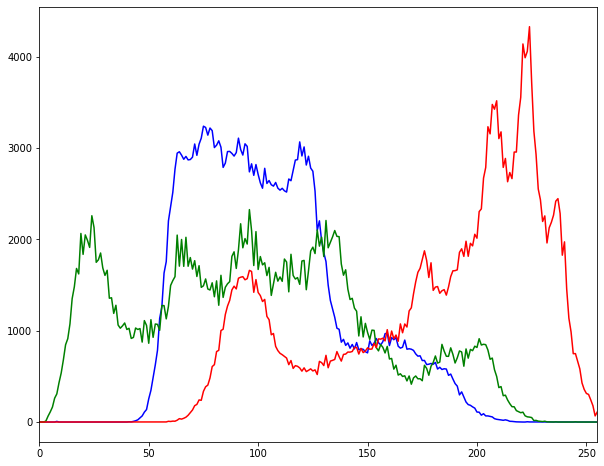

True

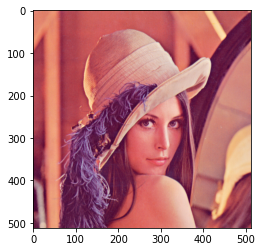

In [2]:
img0 = cv.imread('../a01images/Lenna.png' ,cv.IMREAD_COLOR)

fig, axes= plt.subplots(figsize=(10,8))#, sharex='all', sharey='all', figsize=(13,13))
channels = ['b', 'g', 'r'] # since opencv reads img as BGR channel order
for i, channel in enumerate(channels):
#histogram = cv.calcHist(images, channels, mask, histSize, ranges)
    histogram = cv.calcHist([img0], [i], None, [256], [0,256])
    plt.plot(histogram, color = channel)
    plt.xlim([0, 255])
plt.savefig('LaTeX Report/figures/hiscomp.eps')
plt.show()

plt.imshow(cv.cvtColor(img0, cv.COLOR_BGR2RGB)) 
cv.imwrite('LaTeX Report/figures/img0.png',img0)

## (b) Histogram equalization. Show the histogram before and after.

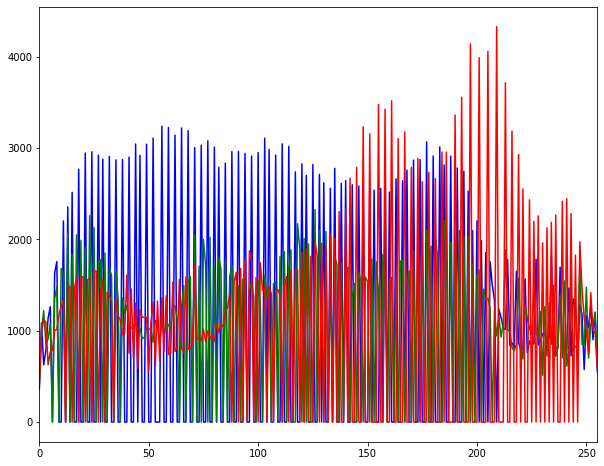

True

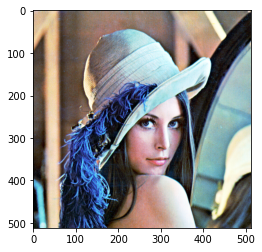

In [3]:
equalized_channels = []
for channel in cv.split(img0):
    equalized_channels.append(cv.equalizeHist(channel)) # source 8-bit single channel image.
equalized_img = cv.merge(equalized_channels)

fig, axes= plt.subplots(figsize=(10,8))
for i, channel in enumerate(channels):
#histogram = cv.calcHist(images, channels, mask, histSize, ranges)
    histogram = cv.calcHist([equalized_img], [i], None, [256], [0,256])
    plt.plot(histogram, color = channel)
    plt.xlim([0, 255])
plt.savefig('LaTeX Report/figures/hisequ.eps')
plt.show()
plt.imshow(cv.cvtColor(equalized_img, cv.COLOR_BGR2RGB))
cv.imwrite('LaTeX Report/figures/equalized_img.png',equalized_img)

## (c) Intensity transformations

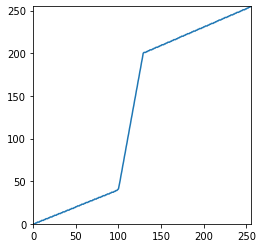

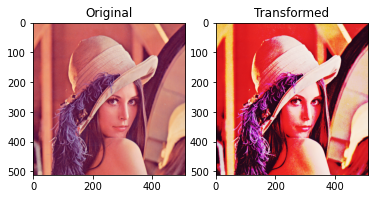

In [4]:
img = cv.imread('../a01images/Lenna.png', cv.IMREAD_COLOR)

a, b = [40,200]

tr1 = np.linspace(0,a,100).astype('uint8')
tr2 = np.linspace(a+1,b,30).astype('uint8')
tr3 = np.linspace(b+1,255,126).astype('uint8')

transf = np.concatenate((tr1, tr2), axis = 0)
transf = np.concatenate((transf, tr3), axis = 0)

fig, ax = plt.subplots()
ax.plot(transf)
ax.set_xlim(0,255)
ax.set_ylim(0,255)
ax.set_aspect('equal')
#ax.set_title('transformation')
plt.savefig('LaTeX Report/figures/transformation.eps')
plt.show()

fig, ax = plt.subplots(1,2)
ax[0].imshow(img[:,:,::-1], cmap ='gray', vmin = 0, vmax = 255)
ax[0].set_title('Original')
cv.imwrite('LaTeX Report/figures/boriginal.png',img)
img2 = cv.LUT(img, transf)
ax[1].imshow(img2[:,:,::-1], cmap = 'gray', vmin = 0, vmax = 255)
ax[1].set_title('Transformed')
cv.imwrite('LaTeX Report/figures/btransformed.png',img2)
plt.show()

## d)Gamma correction.

In [5]:
img = cv.imread('../a01images/gamma1.jpg', cv.IMREAD_COLOR)
cv.imwrite('LaTeX Report/figures/doriginal.png',img)

def gammacorrect(image, gammaval):
    table = np.array([(i/255.0)**(gamma)*255.0 for i in np.arange(0,256)]).astype('uint8')
    img_gamma = cv.LUT(image, table)
    cv.imwrite('LaTeX Report/figures/dgamma' + str(gammaval)[-1] +'.png',img_gamma)
    
gammas = [0.4,0.7,1.3]
for gamma in gammas:
    gammacorrect(img, gamma)

## (e) Gaussian smoothing. State kernel size and SIGMA

In [6]:
img = cv.imread('../a01images/Lenna.png', cv.IMREAD_REDUCED_GRAYSCALE_2)
cv.imwrite('LaTeX Report/figures/eoriginal.png',img)
def gaussianSmooth(kernelSize, sigma):
    max_abs = np.floor(kernelSize/2)
    x_range = np.arange(-max_abs,max_abs +1,1) #(form -5 to +5 range)
    y_range = np.arange(-max_abs,max_abs +1,1) #(form -5 to +5 range)

    X,Y = np.meshgrid(x_range, y_range)

    Z = np.exp((-(X**2 + Y**2))/(2*sigma**2))/(2*np.pi*sigma**2) # Gaussian function
    kernel = Z
    smoothed_img = cv.filter2D(img,-1,kernel)
    cv.imwrite('LaTeX Report/figures/SmoothkernelS'+str(kernelSize)+'.png',smoothed_img)

sigma = 1.5
ksizes = [7,13,21]
for kernelSize in ksizes:
    gaussianSmooth(kernelSize, sigma)

## (f ) Unsharp masking.

In [7]:
img = cv.imread('../a01images/moon.jpg', cv.IMREAD_GRAYSCALE)
cv.imwrite('LaTeX Report/figures/foriginal.png',img)

sigma = 2
kernel = cv.getGaussianKernel(5, sigma) #create the gaussian kernel

blurred = cv.sepFilter2D(img, -1, kernel, kernel, anchor=(-1,-1), delta=0, borderType=cv.BORDER_REPLICATE)
mask = img.astype('float32') - blurred.astype('float32')
k = 1 # when k =1 : unsharp masking, when k>1 : Highboost Filtering
#dst= cv.addWeighted(src1, alpha, src2, beta, gamma)
sharpened = cv.addWeighted(img.astype('float32') , 1., mask, k, 0)

cv.imwrite('LaTeX Report/figures/blurred.png',blurred,)
cv.imwrite('LaTeX Report/figures/mask.png',mask+120)
cv.imwrite('LaTeX Report/figures/sharpened.png',sharpened)

True

## (g) Median filtering. State kernel size.

In [8]:
from scipy import stats

def noisy(noise_typ,image):    
    """
    Parameters
    ----------
    image : ndarray
        Input image data. Will be converted to float.
    mode : str
        One of the following strings, selecting the type of noise to add:

        'gauss'     Gaussian-distributed additive noise.
        'poisson'   Poisson-distributed noise generated from the data.
        's&p'       Replaces random pixels with 0 or 1.
        'speckle'   Multiplicative noise using out = image + n*image,where
                    n is uniform noise with specified mean & variance.
        
        Source: https://stackoverflow.com/a/30609854
    """    
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 100.
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        noisy = np.clip(noisy, 0.0, 255.0)
        print(stats.describe(noisy.ravel()))
        return noisy
    elif noise_typ == "s&p":
        # row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.2
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        noisy = np.clip(noisy, 0.0, 255.0)
        return noisy

In [9]:
img = cv.imread('../a01images/Lenna.png', cv.IMREAD_COLOR)
cv.imwrite('LaTeX Report/figures/goriginal.png',img)

# noise generated using noisy function avalable at
# Source: https://stackoverflow.com/a/30609854
saltpepper = noisy("s&p", img)
medianfilterimage3 = cv.medianBlur(saltpepper, 3) 
medianfilterimage5 = cv.medianBlur(saltpepper, 5) 

cv.imwrite('LaTeX Report/figures/saltpepper.png',saltpepper)
cv.imwrite('LaTeX Report/figures/medianfilterimage3.png',medianfilterimage3)
cv.imwrite('LaTeX Report/figures/medianfilterimage5.png',medianfilterimage5)

<ipython-input-8-3863c797c6a1>:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 255
<ipython-input-8-3863c797c6a1>:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


True

## (h) Bilateral filtering. Explain the theory of this as well.

In [10]:
img = cv.imread('../a01images/blateral.JPG', cv.IMREAD_REDUCED_GRAYSCALE_2)
cv.imwrite('LaTeX Report/figures/horiginal.png',img)

# noise generated using noisy function avalable at
# Source: https://stackoverflow.com/a/30609854

#dst=cv.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])
gaussianB = cv.GaussianBlur(img, (9,9) ,6,6) #sigma = 6
#dst = cv.bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]])
bl5 = cv.bilateralFilter(img,9,100,6) 
bl9 = cv.bilateralFilter(img,13,10,6) 

cv.imwrite('LaTeX Report/figures/gaussianB.png',gaussianB)
cv.imwrite('LaTeX Report/figures/bl5.png',bl5)
cv.imwrite('LaTeX Report/figures/bl9.png',bl9)

True

# Part 2: Count the rice grains in the rice image

100


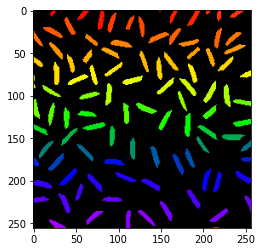

In [11]:
# reading the image a s an eight bit grayscale image
# so the pixel values are in the range 0-255
img = cv.imread("../a01images/rice.png", cv.IMREAD_GRAYSCALE)
cv.imwrite('LaTeX Report/figures/part2/2original.png',img)

#--------------------binary segmentation------------------
# transform input image into pure black and white form
# pure white - rice grains
# pure black - background

# adaptive thresholding due to non uniform illumination in the image
kernelSize, C = 25,-10
img_adapt_thresh = th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,kernelSize, C)
cv.imwrite('LaTeX Report/figures/part2/img_adapt_thresh.png',img_adapt_thresh)

# Morphological transformation:  Erosion
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
# to eliminate white noise and detach connected objects
ksize = 3
kernel = cv.getStructuringElement(cv.MORPH_RECT,(ksize,ksize))
eroded_img = cv.erode(img_adapt_thresh, kernel)
cv.imwrite('LaTeX Report/figures/part2/eroded_img.png',eroded_img)

#---------------------Connected components Analysis(CCA)----------------------
num_labels, labeledImg = cv.connectedComponents(eroded_img)
cv.imwrite('LaTeX Report/figures/part2/labeledImg.png',labeledImg)

# Background is considered as another object in CCA.
# Therfore it needs to be subtracted to get the grain count
num_grains = num_labels -1
print(num_grains)

#-------------------Show components using a color Map.-------------------------

# find min and max pixel values and their locations the image.
(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(labeledImg)

# Normalize the image so the min value is 0 and max value is 255.
labeledImg = (255/(maxVal-minVal)) * (labeledImg - minVal)

# Applying the color map for better visulization
imgColorMap = cv.applyColorMap(labeledImg.astype('uint8'), cv.COLORMAP_RAINBOW)

# Making the background black
imgColorMap[labeledImg==0] = 0
cv.imwrite('LaTeX Report/figures/part2/imgColorMap.png',imgColorMap)

# Display colormapped labels
plt.imshow(imgColorMap[:,:,::-1])

# Part 3: A program to zoom images by a given factor in (0,10].

In [12]:
def zoom(image, scaling_factor, method):
    img = image
    sf = scaling_factor
    # Determining dimensions of the zoomed image
    if len(img.shape) == 2: # for GRAYSCALE images
        zoomedImgDims = [int(dim*sf) for dim in img.shape]
    else: # for COLOR images
        zoomedImgDims = [int(dim*sf) for dim in img.shape]
        zoomedImgDims[2] = 3
    # declaring an empty array to store values
    zoomedImg = np.zeros(zoomedImgDims, dtype = img.dtype)
#====================Nearest Neighbour Mehtod(NNM)=========================
    if method == 'nn':        
        for row in range(zoomedImg.shape[0]):
            # Calculating corresponding pixels in original image 
            source_row = round(row/sf)
            # Overflow handling
            if source_row > img.shape[0]-1: source_row = img.shape[0]-1
            for column in range(zoomedImg.shape[1]):
                # Calculating corresponding pixels in original image        
                source_column = round(column/sf)
                # Overflow handling
                if source_column > img.shape[1]-1: source_column = img.shape[1]-1
                # Assigning pixel values
                if len(img.shape) == 2:
                    zoomedImg[row][column] = img[source_row][source_column]
                else:
                    for channel in range(3):
                        zoomedImg[row][column][channel] = \
                                            img[source_row][source_column][channel]
#======================Bilinear Interpolation Mehtod(BIM)==================     
    if method == 'bi':
        for row in range(zoomedImg.shape[0]):
            # Calculating corresponding row in original image
            row_position = row/sf
            row_below = int(np.floor(row_position))
            row_up = int(np.ceil(row_position))
            if row_up > img.shape[0]-1: row_up = img.shape[0]-1
            for column in range(zoomedImg.shape[1]):
                # Calculating corresponding column in original image       
                column_position = column/sf
                column_previous = int(np.floor(column_position))
                column_next = int(np.ceil(column_position))
                if column_next > img.shape[1]-1: column_next = img.shape[1]-1

                diff1 = row_position - row_below 
                diff2 = column_position - column_previous
                if len(img.shape) == 2: # for GRAYSCALE images
                    interVal1 = img[row_below][column_previous]*(1-diff1)\
                                + img[row_up][column_previous]*(diff1)
                    interVal2 = img[row_below][column_next]*(1-diff1)\
                                + img[row_up][column_next]*(diff1)
                    zoomedImg[row][column] = (interVal1*(1-diff2)\
                                              + interVal2*(diff2)).astype('uint8')
                else: # for COLOR images
                    for channel in range(3):
                        interVal1 = img[row_below][column_previous][channel]*(1-diff1)\
                                + img[row_up][column_previous][channel]*(diff1)
                        interVal2 = img[row_below][column_next][channel]*(1-diff1)\
                                + img[row_up][column_next][channel]*(diff1)
                        zoomedImg[row][column][channel] = (interVal1*(1-diff2)\
                                                           + interVal2*(diff2)).astype('uint8')
    return zoomedImg

In [13]:
img = cv.imread("../a01images/im09small.png", cv.IMREAD_COLOR)
print("Zooming image nnm...")
znn = zoom(img, 4, 'nn')
print("Zooming image bim...")
zbi = zoom(img, 4, 'bi')

imgo = cv.imread("../a01images/im09.png", cv.IMREAD_COLOR)
errornn = np.sum((imgo - znn)**2)
errorbi = np.sum((imgo - zbi)**2)

Zooming image nnm...
Zooming image bim...


In [14]:
cv.imwrite('LaTeX Report/figures/part3/znn.png',znn)
cv.imwrite('LaTeX Report/figures/part3/zbi.png',zbi)
print(errornn-errorbi)

8166895
